In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%matplotlib inline

In [58]:
import yaml
import os
from tqdm import tqdm_notebook

In [59]:
import pandas as pd
import numpy as np

In [290]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

In [61]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

In [289]:
from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images
from utils import imscatter

from model.cae import CAE

In [63]:
from keras.preprocessing.image import ImageDataGenerator

## Read data

In [64]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [65]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
image_size = conf['wsi']['patch_size']

In [66]:
train_df = pd.read_csv(os.path.join(conf['data_path'], 'train.csv'), sep='|')
test_df = pd.read_csv(os.path.join(conf['data_path'], 'test.csv'), sep='|')

In [67]:
data_df = pd.concat([train_df, test_df])

In [68]:
data_df.head(3)

filename                 slide_id       case_id  \
0    TCGA-FB-A4P5-01A-01-TSA_14_71.png  TCGA-FB-A4P5-01A-01-TSA  TCGA-FB-A4P5   
1  TCGA-FZ-5923-01A-01-TS1_052_030.png  TCGA-FZ-5923-01A-01-TS1  TCGA-FZ-5923   
2   TCGA-IB-A5ST-01A-01-TSA_35_133.png  TCGA-IB-A5ST-01A-01-TSA  TCGA-IB-A5ST   

          sample_id                  disease_type    sample_type  \
0  TCGA-FB-A4P5-01A  Ductal and Lobular Neoplasms  Primary Tumor   
1  TCGA-FZ-5923-01A  Ductal and Lobular Neoplasms  Primary Tumor   
2  TCGA-IB-A5ST-01A  Ductal and Lobular Neoplasms  Primary Tumor   

   percent_normal_cells  percent_stromal_cells  percent_tumor_cells  \
0                  20.0                   50.0                 30.0   
1                   0.0                   30.0                 70.0   
2                   6.0                   73.0                 18.0   

   percent_tumor_nuclei  
0                  40.0  
1                  70.0  
2                  20.0

In [15]:
imgen = ImageDataGenerator(rescale=1/255)

data_generator = imgen.flow_from_dataframe(data_df, directory=patches_path, x_col='filename', 
                                            target_size=(image_size, image_size), color_mode='rgb', class_mode=None, shuffle=False)


# test_generator = imgen.flow_from_dataframe(test_df, directory=patches_path, x_col='filename', 
                                           # target_size=(image_size, image_size), color_mode='rgb', class_mode=None, shuffle=False)

Found 72265 images.


## CAE Predictions 

__Load CAE__

In [16]:
model = 'model_2'

In [17]:
cae = CAE(path=os.path.join(conf['data_path'], 'models', model), load=True)

Instructions for updating:
Colocations handled automatically by placer.


/home/jupyter/TFM/model/cae.py:80: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


__Encode on train and test__

In [18]:
data_enc = cae.encoder.predict_generator(data_generator, 
                                         steps=len(data_generator), 
                                         workers=8, 
                                         verbose=1)

2259/2259 [==============================] - 186s 82ms/step


## PCA Dimensionality Red

In [23]:
pca = PCA(n_components=30)

In [24]:
data_enc_pca = pca.fit_transform(data_enc)

Explained variance

In [25]:
expl_variance = pd.DataFrame({'feature': range(1, pca.n_components + 1),
                              'explained_var': pca.explained_variance_ratio_,
                              'cumulative_explained_var': np.cumsum(pca.explained_variance_ratio_)})

expl_variance[['feature', 'explained_var', 'cumulative_explained_var']].head(10)

feature  explained_var  cumulative_explained_var
0        1       0.292693                  0.292693
1        2       0.074212                  0.366905
2        3       0.035865                  0.402771
3        4       0.022575                  0.425346
4        5       0.012229                  0.437575
5        6       0.011561                  0.449136
6        7       0.009868                  0.459004
7        8       0.009084                  0.468088
8        9       0.008646                  0.476734
9       10       0.008060                  0.484794

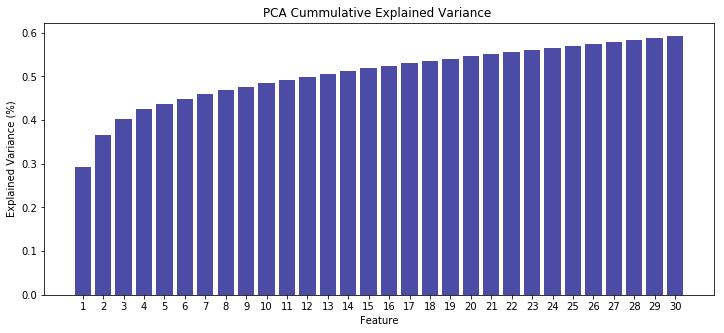

In [26]:
plt.figure(figsize=(12,5))
plt.bar(expl_variance['feature'] - 1, expl_variance['cumulative_explained_var'], align='center', alpha=0.7, color='navy')
plt.xlabel('Feature')
plt.xticks(range(pca.n_components), expl_variance['feature'])
plt.title('PCA Cummulative Explained Variance ')
plt.ylabel('Explained Variance (%)')
pass

## K-Means Clustering

__Elbow method (select K)__

In [95]:
Ks = list(range(3,20))
inertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_enc_pca)
    
    inertias.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow method for selecting optimal K')

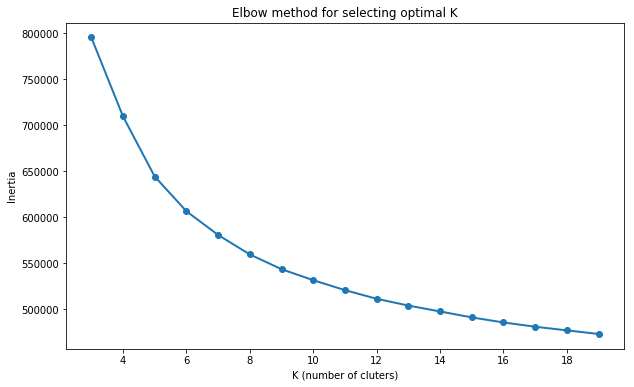

In [291]:
plt.figure(figsize=(10,6))

plt.plot(Ks, inertias, lw=2, marker='o')
plt.xlabel('K (number of cluters)')
plt.ylabel('Inertia')
plt.title('Elbow method for selecting optimal K')

__Train best K__

In [231]:
K = 8
kmeans = KMeans(n_clusters=K)

In [98]:
data_cluster = kmeans.fit_predict(data_enc_pca)

In [99]:
data_df['cluster'] = data_cluster

In [100]:
data_df['cluster'].value_counts()

7    16006
3    15612
2    13609
0    12820
5     6671
1     5235
4     2117
6      195
Name: cluster, dtype: int64

 Cluster 0


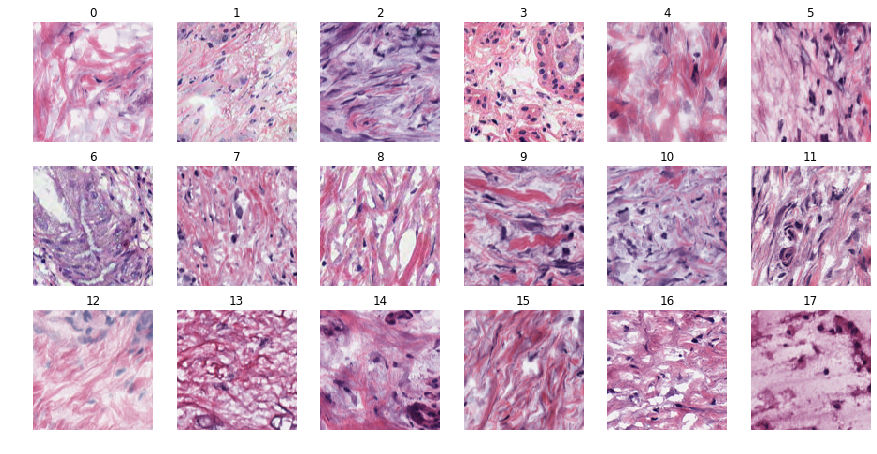

 Cluster 1


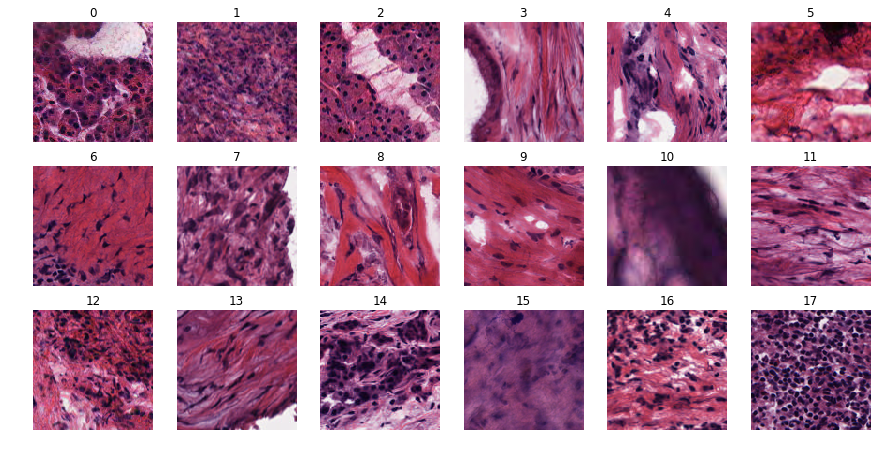

 Cluster 2


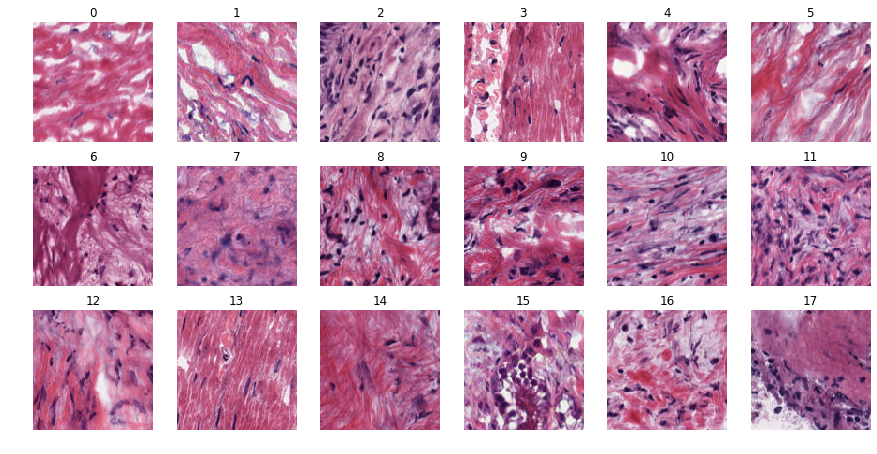

 Cluster 3


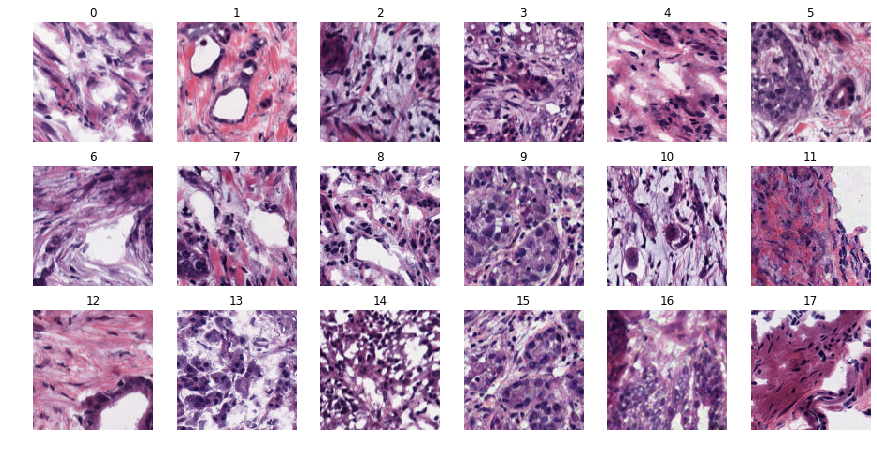

 Cluster 4


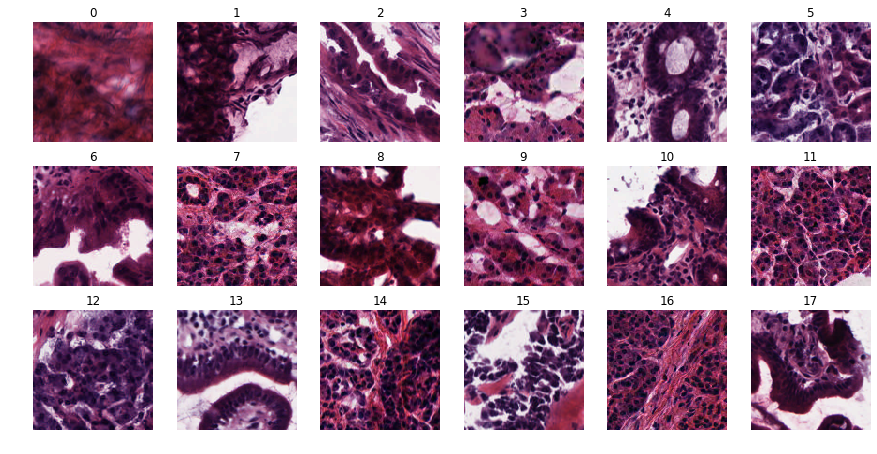

 Cluster 5


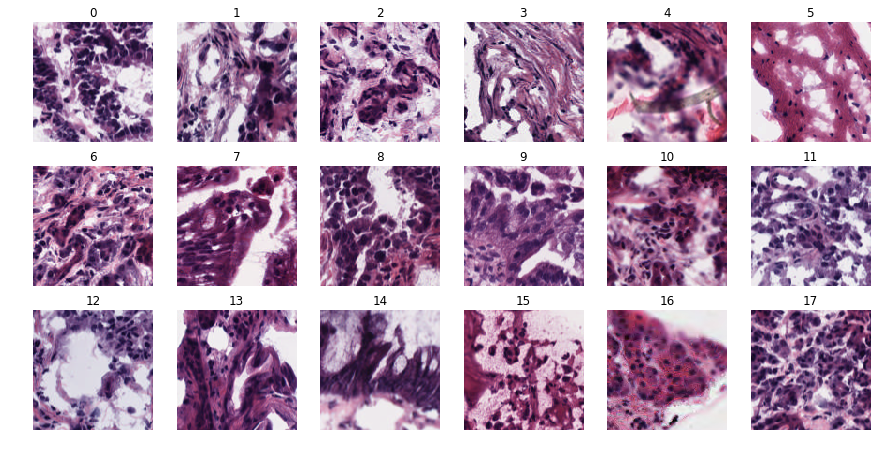

 Cluster 6


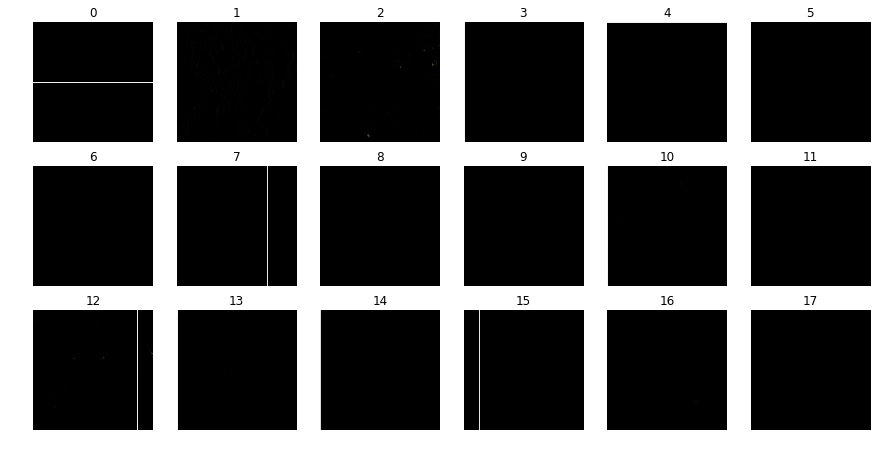

 Cluster 7


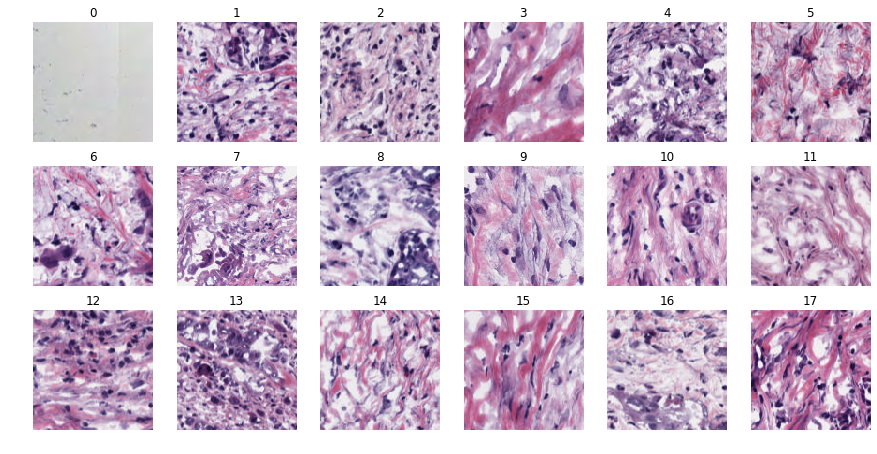

In [101]:
for cluster in range(K):
    
    print('\033[1m Cluster {}'.format(cluster))
    
    sample_data = data_df[data_df['cluster'] == cluster].sample(20)
    sample_imgs = read_images(sample_data['filename'], patches_path)
    
    plot_sample_imgs(sample_imgs, n_rows=3, n_cols=6, size=2.5, color=True, shuffle=False)
    plt.show()

__Cluster analysis__

In [152]:
cluster_counts = data_df.groupby(['cluster']).size().reset_index().rename(columns={0: 'total'})
cluster_counts

cluster  total
0        0  12820
1        1   5235
2        2  13609
3        3  15612
4        4   2117
5        5   6671
6        6    195
7        7  16006

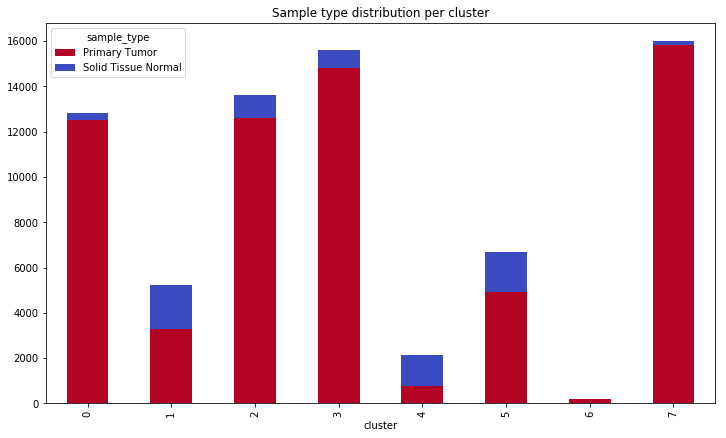

In [148]:
data_df.groupby(['cluster', 'sample_type']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,7), cmap='coolwarm_r')
plt.title('Sample type distribution per cluster')
pass

In [150]:
data_df.groupby(['cluster', 'sample_type']).size().unstack()

sample_type  Primary Tumor  Solid Tissue Normal
cluster                                        
0                  12516.0                304.0
1                   3281.0               1954.0
2                  12599.0               1010.0
3                  14833.0                779.0
4                    775.0               1342.0
5                   4922.0               1749.0
6                    195.0                  NaN
7                  15843.0                163.0

Text(0.5, 1.0, 'Average distribution of cell types in each cluster')

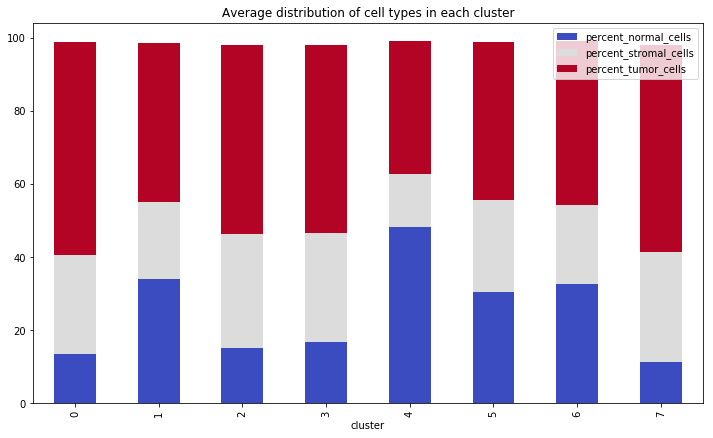

In [147]:
data_df.groupby(['cluster'])[['percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells']].mean().plot(kind='bar', stacked=True, figsize=(12,7), cmap='coolwarm')
plt.title('Average distribution of cell types in each cluster')

__Sample image representation in PCA 2D__

In [292]:
data_df['pca1'] = data_enc_pca[:,0]
data_df['pca2'] = data_enc_pca[:,1]
data_df['paths'] = data_df['filename'].map(lambda x: os.path.join(patches_path, x))

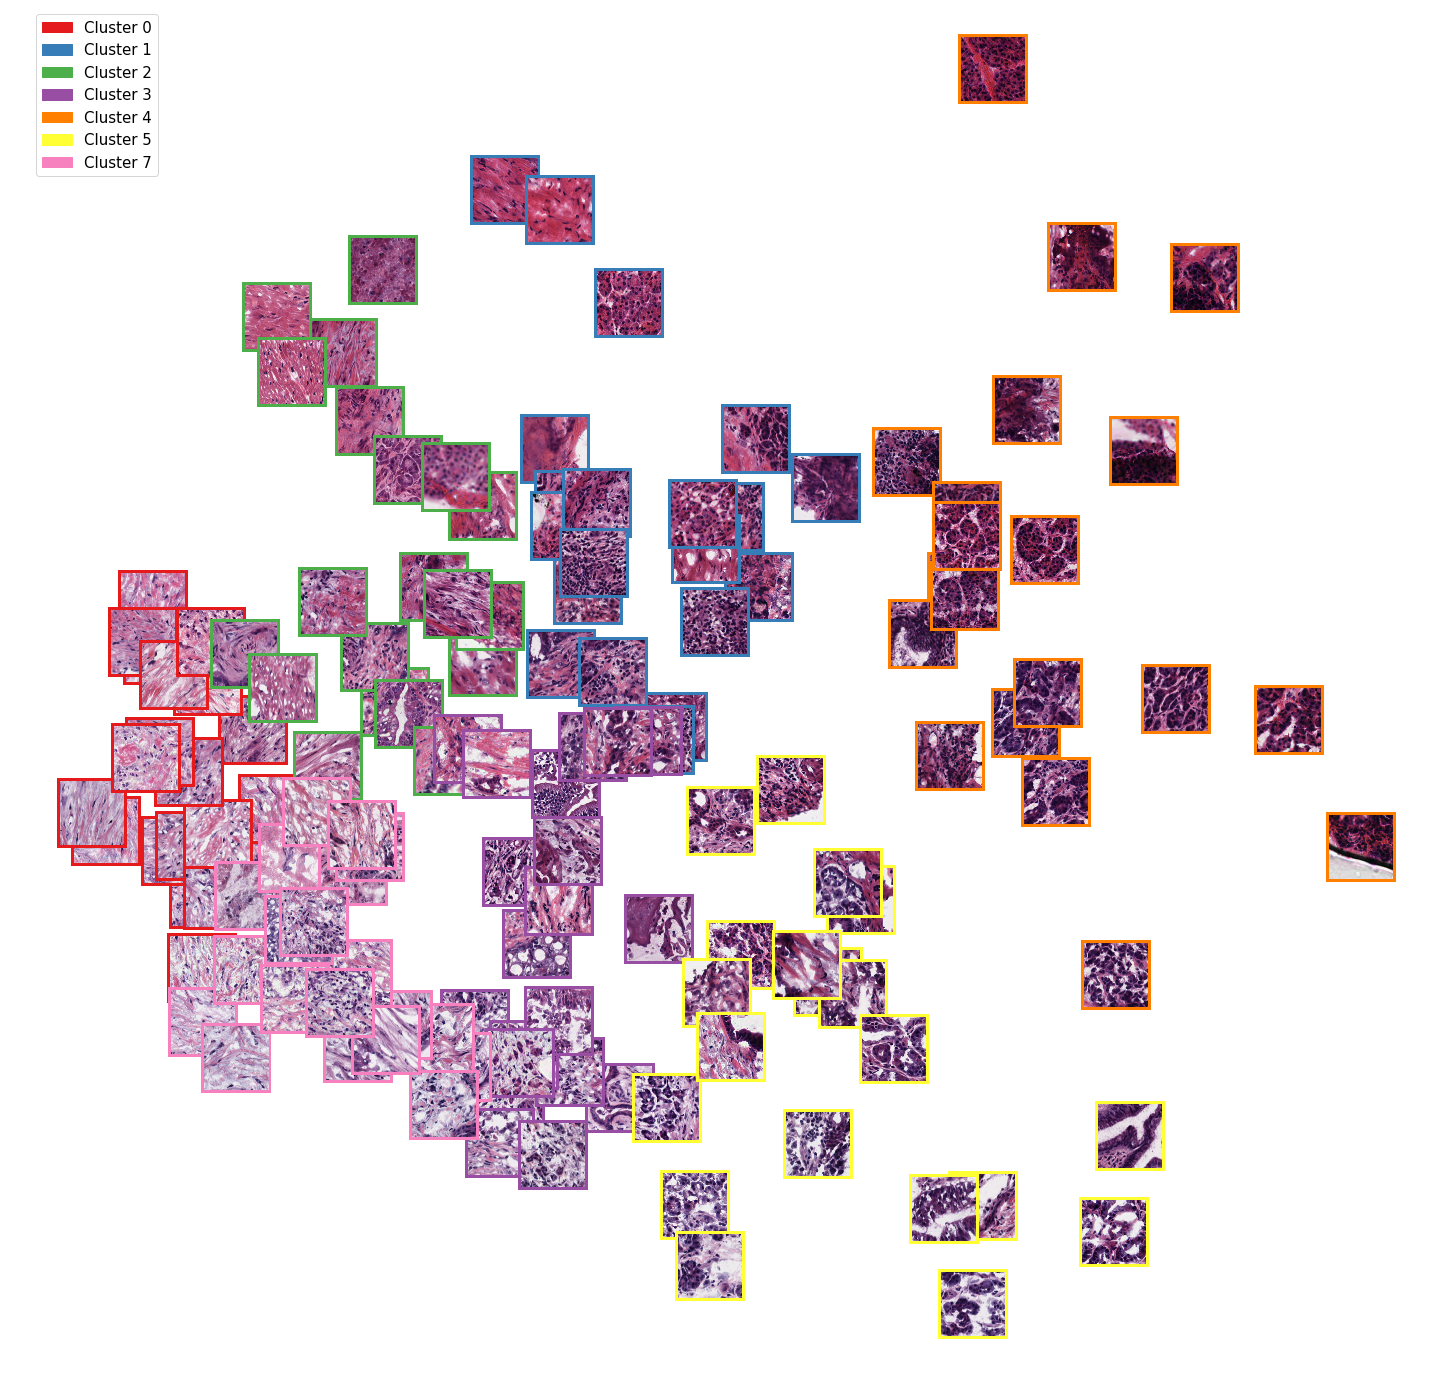

In [295]:
fig, ax = plt.subplots(figsize=(25,25))
cmap = cm.get_cmap('Set1')
n_samples = 20

legend_elements = []

for cluster in range(K):  
    
    if cluster == 6:
        continue
        
    color = cmap(cluster / K)
    samples = data_df[data_df['cluster'] == cluster].sample(n_samples)
    
    imscatter(samples['pca1'], samples['pca2'], samples['paths'], zoom=0.5, ax=ax, color=color, lw=6)
    legend_elements.append(Patch(facecolor=color, edgecolor=color, label='Cluster {}'.format(cluster)))
    
    
ax.legend(handles=legend_elements, loc='upper left', prop={'size': 15})

plt.axis('off')
plt.show()